JAX [@jax2018github] implementation of the score-driven model featuring location, scale and shape common factors introduced in Labonne P. (2024). "Asymmetric uncertainty: Nowcasting using skewness in real-time data". *International Journal of Forecasting*

JAX adds automatic differentiation and high-performance numerical computing features to code written in Python.

#### First install all necessary python libraries

In [ ]:
%%capture

! pip install -r requirements.txt

#### R code for building a dataframe from fred-md vintages. The dataframe is saved in the `arrow` `parquet` format for easy interoperability with Python.

In [ ]:
%%capture

# first install all necessary packages
! Rscript "R/install.R"

# build the dataframe
! Rscript "R/fredmd.R"

#### Load the dataframe in `Python`

In [1]:
import pyarrow.parquet as pq

# load the data
df = pq.read_table("data/df_fredmd.parquet").to_pandas()

#### Estimation with maximum likelihood

In [2]:
import sys
sys.path.append('src') # to find sdfm
from sdfm import build_model
from sdfm import mle

import jax
import jax.numpy as jnp
from jax import random

# convert the data to a JAX type
df_np = df.to_numpy() # for easy use with JAX
y = jnp.array(df_np[:, 1:])

# build the model
slack_model = build_model(y)

# estimation with maximum likelihood
key = jax.random.PRNGKey(123)
mle_result = mle(model=slack_model, iter=100, pertu=0.25, key=key)

print("ML at", -mle_result.fun)

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]

ML at -4149.11669921875


#### Run the filter with the estimated parameters

In [3]:

from sdfm import sd_filter
estimated_filter = sd_filter(mle_result.x, slack_model)

#### Plot of the estimated common factors

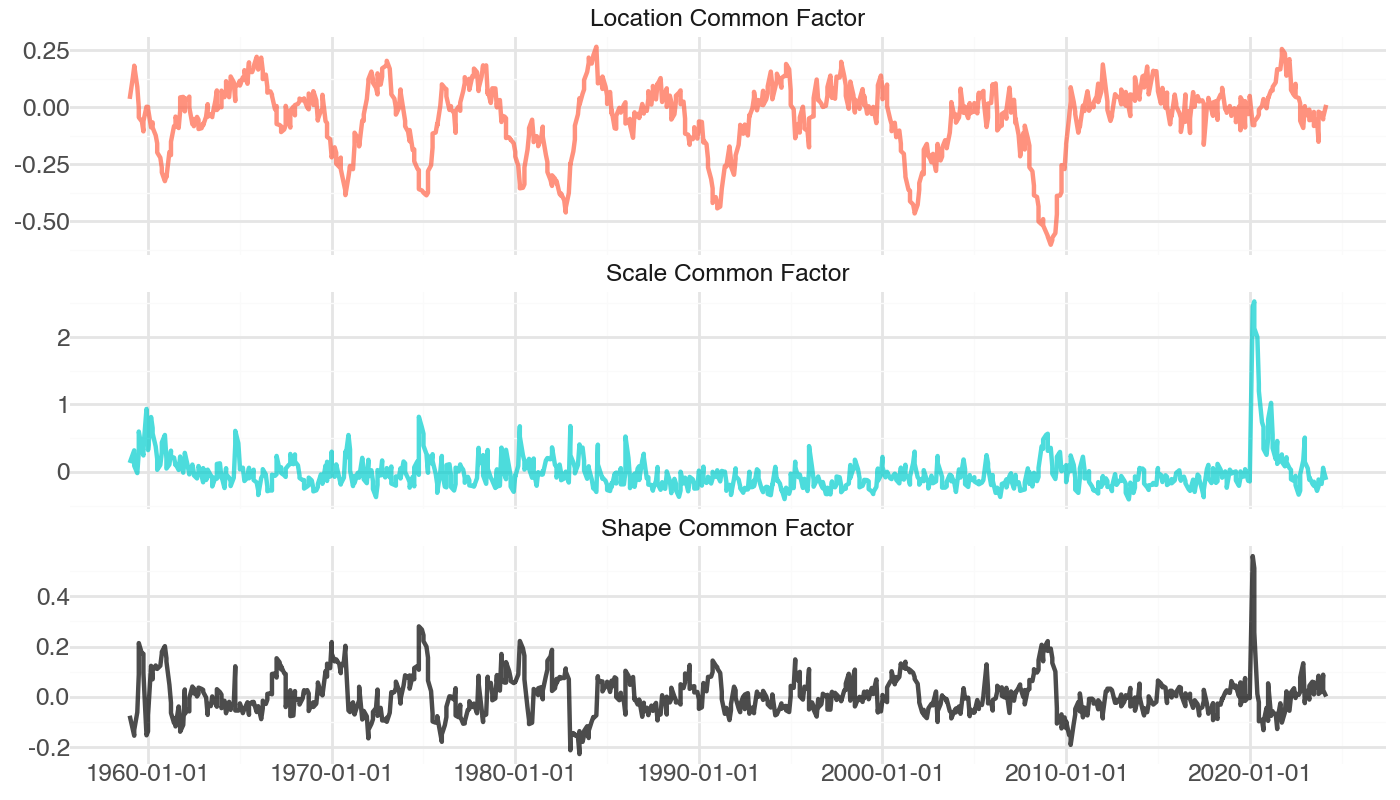

In [4]:
#| echo: false
import pandas as pd

from plotnine import (
    ggplot,
    aes,
    geom_line,
    labs,
    theme_minimal,
    facet_wrap,
    theme,
    scale_x_datetime,
    scale_color_manual,
)


# first deal with the dates
# Function to convert yearmon from numeric format
def convert_yearmon(yearmon):
    year = int(yearmon)
    month = int((yearmon - year) * 12 + 1)  # Adjusting for base-1 index
    return pd.Timestamp(year=year, month=month, day=1)


# Apply the conversion function
dates = pd.to_numeric(df["date"])
dates = dates.apply(convert_yearmon)

# create dataframe for plotting
df_plot = pd.DataFrame(
    {
        "date": dates,
        "Location Common Factor": estimated_filter[0][0, :, y.shape[1]],
        "Scale Common Factor": estimated_filter[0][1, :, y.shape[1]],
        "Shape Common Factor": estimated_filter[0][2, :, y.shape[1]],
    }
)

df_plot = df_plot.melt("date", var_name="variable", value_name="value")

# Plotting
plot = (
    ggplot(df_plot, aes(x="date", y="value", color="variable"))
    + geom_line(alpha=0.7, size = 0.9)
    + labs(title="", x="", y="")
    + theme_minimal()
    + theme(figure_size=(7, 4), legend_position="none")
    + scale_x_datetime(date_breaks="10 years")
    + scale_color_manual(values=["tomato", "#00CDCD", "black"])  # Custom colors
    + facet_wrap("~variable", scales="free_y", nrow=3)
)

# Display the plot
plot.show()